In [112]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [9]:
spam_data = pd.read_csv('spam.csv')
spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head()

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [13]:
print "Total spam cases: %d\nTotal non spam cases: %d" %(spam_data.target.value_counts()[0],spam_data.target.value_counts()[1])

Total spam cases: 4825
Total non spam cases: 747


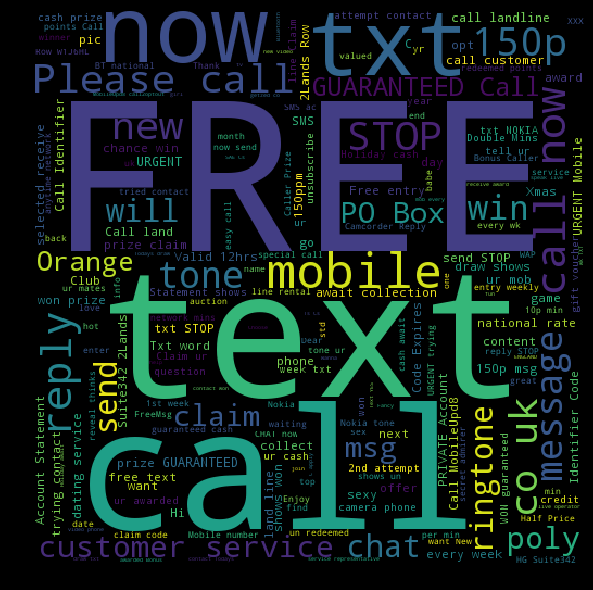

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

spam_words = ' '.join(list(spam_data[spam_data['target']==1]['text']))
spam_wordcount = WordCloud(width = 512, height =512).generate(spam_words)
plt.figure(figsize =(10,8), facecolor = 'k')
plt.imshow(spam_wordcount)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

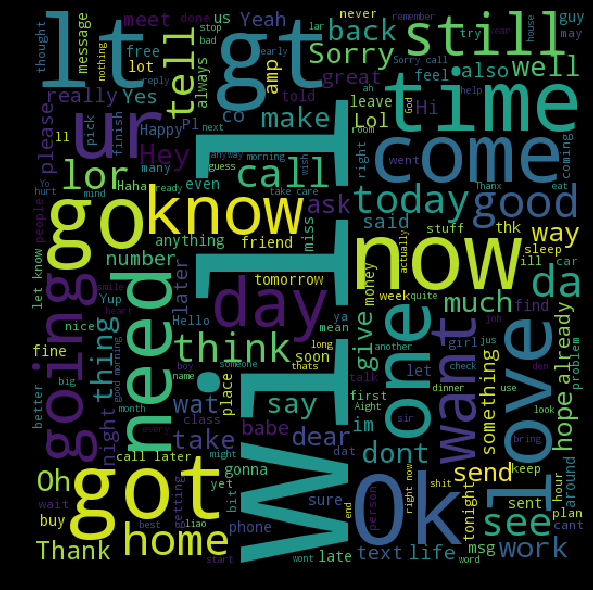

In [110]:
not_spam_words = ' '.join(list(spam_data[spam_data['target']==0]['text']))
not_spam_wordcount = WordCloud(width = 512, height =512).generate(not_spam_words)
plt.figure(figsize =(10,8), facecolor = 'k')
plt.imshow(not_spam_wordcount)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

We will implement TF-IDF strategy to train the model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], spam_data['target'], random_state=0)

# Fit and transform the training data X_train using a Count Vectorizer with default parameters.
vect = TfidfVectorizer().fit(X_train)
print "Total features generated by CountVectorizer using default parameters %d" %(len(vect.get_feature_names()))

In [59]:
# Keep minimum document frequency = 3

vect = TfidfVectorizer(min_df=3).fit(X_train)
print "Total features generated by CountVectorizer %d" %(len(vect.get_feature_names()))

Total features generated by CountVectorizer 2295


In [85]:
# Let us take a look at 5 features have the smallest tf-idf and 5 have the largest tf-idf
    
def smallest_largest_tfidf(X_train_vectorized, feature_names):
    
    sorted_tfidf_index = X_train_vectorized.max(0).toarray()[0].argsort()
    small_index = feature_names[sorted_tfidf_index[:5]]
    small_value = X_train_vectorized.max(0).toarray()[0][sorted_tfidf_index[:5]]
    smallTuples = [(value, word) for word, value in zip(small_index, small_value)]
    smallTuples.sort()
    small_index = [element[1] for element in smallTuples]
    small_value = [element[0] for element in smallTuples]
    small_series = pd.Series(small_value,index=small_index)

    big_index = feature_names[sorted_tfidf_index[-5:]]
    big_value = X_train_vectorized.max(0).toarray()[0][sorted_tfidf_index[-5:]]
    bigTuples = [(-value, word) for word, value in zip(big_index, big_value)]
    bigTuples.sort()
    big_index = [element[1] for element in bigTuples]
    big_value = [-element[0] for element in bigTuples]
    big_series = pd.Series(big_value,index=big_index)
    return (small_series, big_series)
    
X_train_vectorized = vect.transform(X_train)
feature_names = np.array(vect.get_feature_names())
smallest_largest_tfidf(X_train_vectorized, feature_names)

(moral         0.204078
 36504         0.215685
 sum1          0.216737
 100percent    0.217856
 genuine       0.217856
 dtype: float64, anytime    1.0
 say        1.0
 type       1.0
 unsold     1.0
 where      1.0
 dtype: float64)

## Model 1 

A simple logistic model using only TFIDF (term frequency–inverse document frequency) as features.

In [159]:
from sklearn import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Tune parameters of our Logistic reression model

X_train_vectorized = vect.transform(X_train)
param_grid = {'C':[1,10,100,1000]}
model = LogisticRegression()
grid = GridSearchCV(model,param_grid)
grid.fit(X_train_vectorized,y_train)
grid.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [163]:
from sklearn.metrics import roc_auc_score

#Fit and transform the training data X_train using a Tfidf Vectorizer 
#Ignore terms that have a document frequency strictly lower than 3.

def model1(cval): 
    vect = TfidfVectorizer(min_df=3).fit(X_train)
    X_train_vectorized = vect.transform(X_train)
    model = LogisticRegression(C=cval)
    model.fit(X_train_vectorized, y_train)
    predictions = model.predict(vect.transform(X_test))
    p,r,f,s = precision_recall_fscore_support(y_test, predictions, pos_label=1, average='binary')
    acc = accuracy_score(y_test, predictions)
    AUC = roc_auc_score(y_test, predictions)
    print " MODEL 1\n"
    print " AUC: %0.3f\n Accuracy: %0.3f\n Precision: %0.3f\n Recall: %0.3f\n F1-Score: %0.3f" %(AUC,acc,p,r,f)
    return

model1(100)

 MODEL 1

 AUC: 0.958
 Accuracy: 0.986
 Precision: 0.984
 Recall: 0.919
 F1-Score: 0.950


## FEATURE ENGINEERING 

Let us look at the average length of documents (number of characters) for not spam and spam documents

Average length of spam documents 139.7590
Average length of non-spam documents 71.1328


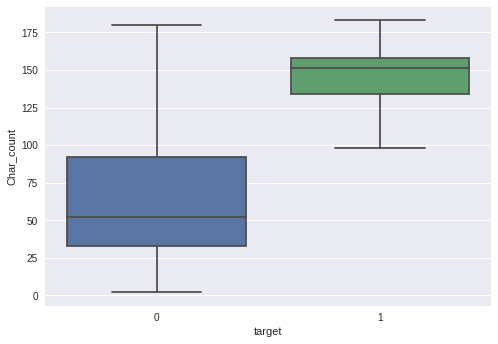

In [94]:
def character_length():
    spam_data['Char_count'] = spam_data['text'].str.len()
    spam_average = spam_data[spam_data['target'] == 1]['Char_count'].values.mean()
    not_spam_average = spam_data[spam_data['target'] == 0]['Char_count'].values.mean()
    print "Average length of spam documents %0.4f" %(spam_average)
    print "Average length of non-spam documents %0.4f" %(not_spam_average)
    sns.boxplot(x="target", y="Char_count", data=spam_data, showfliers=False)
    return 

character_length()

Let us look at the average number of digits per document for not spam and spam documents.

Average number of digits in spam documents 15.7590
Average number of digits in non-spam documents 0.2993


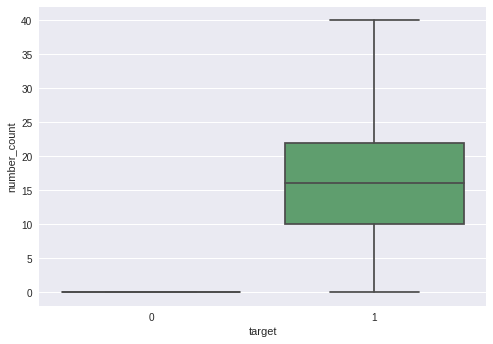

In [98]:
def digit_count():
    import re
    spam_data['number_count'] = spam_data['text'].apply(lambda x: len(re.findall("[0-9]",x)))
    spam_nc_average = spam_data[spam_data['target'] == 1]['number_count'].values.mean()
    not_spam_nc_average = spam_data[spam_data['target'] == 0]['number_count'].values.mean()
    print "Average number of digits in spam documents %0.4f" %(spam_nc_average)
    print "Average number of digits in non-spam documents %0.4f" %(not_spam_nc_average)
    sns.boxplot(x="target", y="number_count", data=spam_data, showfliers=False)
    return    

digit_count()

Let us look at the average number of non-word characters not spam and spam documents(anything other than a letter, digit or underscore).

Average number of non-word characters in spam documents 30.3896
Average number of non-word characters in non-spam documents 17.4864


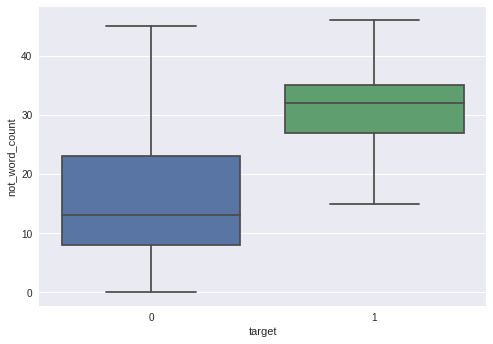

In [96]:
def not_word():
    import re
    spam_data['not_word_count'] = spam_data['text'].apply(lambda x: len(re.findall("\W",x)))
    spam_nw_average = spam_data[spam_data['target'] == 1]['not_word_count'].values.mean()
    not_spam_nw_average = spam_data[spam_data['target'] == 0]['not_word_count'].values.mean()
    print "Average number of non-word characters in spam documents %0.4f" %(spam_nw_average)
    print "Average number of non-word characters in non-spam documents %0.4f" %(not_spam_nw_average)
    sns.boxplot(x="target", y="not_word_count", data=spam_data, showfliers=False)
    return 

not_word()

In [42]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

## Model 2 
Adding the engineered features.

In [160]:
from sklearn.linear_model import LogisticRegression

def model2(c_val):
    vect = TfidfVectorizer(min_df=3).fit(X_train)
    
    X_train_vectorized = vect.transform(X_train)
    X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())
    
    X_train_digits = X_train.str.findall(r'(\d)')
    X_train_vectorized = add_feature(X_train_vectorized, map(len, X_train_digits))
    
    X_train_nonChar = X_train.str.findall(r'(\W)')
    X_train_vectorized = add_feature(X_train_vectorized, map(len, X_train_nonChar))

    X_test_vectorized = vect.transform(X_test)
    X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
    
    X_test_digits = X_test.str.findall(r'(\d)')
    X_test_vectorized = add_feature(X_test_vectorized, map(len, X_test_digits))
    
    X_test_nonChar = X_test.str.findall(r'(\W)')
    X_test_vectorized = add_feature(X_test_vectorized, map(len, X_test_nonChar))

    model = LogisticRegression(C=c_val)
    model.fit(X_train_vectorized, y_train)

    predictions = model.predict(X_test_vectorized)

    p,r,f,s = precision_recall_fscore_support(y_test, predictions, pos_label=1, average='binary')
    acc = accuracy_score(y_test, predictions)
    AUC = roc_auc_score(y_test, predictions)
    print "\n MODEL 2 --> Logistic Regression (C = %d)\n" %(c_val)
    print " AUC: %0.3f\n Accuracy: %0.3f\n Precision: %0.3f\n Recall: %0.3f\n F1-Score: %0.3f\n" %(AUC,acc,p,r,f)
    return 

model2(1)
model2(100)


 MODEL 2 --> Logistic Regression (C = 1)

 AUC: 0.936
 Accuracy: 0.978
 Precision: 0.961
 Recall: 0.878
 F1-Score: 0.918


 MODEL 2 --> Logistic Regression (C = 100)

 AUC: 0.968
 Accuracy: 0.989
 Precision: 0.984
 Recall: 0.939
 F1-Score: 0.961



## Model 3

To improve the model let us add character n-grams from n=2 to n=5. To tell Count Vectorizer to use character n-grams pass in analyzer='char_wb' which creates character n-grams only from text inside word boundaries. This should make the model more robust to spelling mistakes.

In [161]:
def model3(c_val,get_coefficients=None):
    vect = TfidfVectorizer(min_df=5, ngram_range=(2,5), analyzer='char_wb').fit(X_train)
    
    X_train_vectorized = vect.transform(X_train)
    X_train_vectorized = add_feature(X_train_vectorized, X_train.str.len())
    
    X_train_digits = X_train.str.findall(r'(\d)')
    X_train_vectorized = add_feature(X_train_vectorized, map(len, X_train_digits))
    
    X_train_nonChar = X_train.str.findall(r'(\W)')
    X_train_vectorized = add_feature(X_train_vectorized, map(len, X_train_nonChar))
    
    X_test_vectorized = vect.transform(X_test)
    X_test_vectorized = add_feature(X_test_vectorized, X_test.str.len())
    
    X_test_digits = X_test.str.findall(r'(\d)')
    X_test_vectorized = add_feature(X_test_vectorized, map(len, X_test_digits))
    
    X_test_nonChar = X_test.str.findall(r'(\W)')
    X_test_vectorized = add_feature(X_test_vectorized, map(len, X_test_nonChar))

    model = LogisticRegression(C=c_val)
    model.fit(X_train_vectorized, y_train)

    predictions = model.predict(X_test_vectorized)
    feature_names = np.array(vect.get_feature_names())
    feature_names = np.concatenate((feature_names, np.array(['length_of_doc', 'digit_count', 'non_word_char_count'])))

    sorted_coef_index = model.coef_[0].argsort()
    small_coefficient = list(feature_names[sorted_coef_index[:10]])
    large_coefficient = list(feature_names[sorted_coef_index[:-11:-1]])  
    
    p,r,f,s = precision_recall_fscore_support(y_test, predictions, pos_label=1, average='binary')
    acc = accuracy_score(y_test, predictions)
    AUC = roc_auc_score(y_test, predictions)
    print "\n MODEL 3 --> Logistic Regression (C = %d)\n" %(c_val)
    print " AUC: %0.3f\n Accuracy: %0.3f\n Precision: %0.3f\n Recall: %0.3f\n F1-Score: %0.3f\n" %(AUC,acc,p,r,f)
    
    if get_coefficients == "True" :
        print "Largest coefficients found  : ", large_coefficient
        print "Smallest coefficients found  : ", small_coefficient
    return 

model3(1)
model3(100)


 MODEL 3 --> Logistic Regression (C = 1)

 AUC: 0.936
 Accuracy: 0.978
 Precision: 0.961
 Recall: 0.878
 F1-Score: 0.918


 MODEL 3 --> Logistic Regression (C = 100)

 AUC: 0.973
 Accuracy: 0.991
 Precision: 0.984
 Recall: 0.949
 F1-Score: 0.966

